# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [44]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [45]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

In [46]:
corpus 

['\tsonnets',
 '',
 '',
 '',
 'to the only begetter of',
 'these insuing sonnets',
 'mr. w. h. all happiness',
 'and that eternity',
 'promised by',
 'our ever-living poet wisheth',
 'the well-wishing',
 'adventurer in',
 'setting forth',
 't. t.',
 '',
 '',
 'i.',
 '',
 'from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content',
 'and, tender churl, makest waste in niggarding.',
 '  pity the world, or else this glutton be,',
 "  to eat the world's due, by the grave and thee.",
 '',
 'ii.',
 '',
 'when forty winters shall beseige thy b

# Import required library
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove sonnet numbers (roman numerals)
    text = re.sub(r'^[ivxlc]+\.', '', text)
    # Keep punctuation that matters for meaning
    text = re.sub(r'[^a-z\s\',.!?:;]', '', text)
    return text.strip()

# Process sonnets
lines = data.split('\n')
start_index = 0
for i, line in enumerate(lines):
    if 'from fairest creatures we desire increase' in line.lower():
        start_index = i
        break

# Create corpus with proper line structure
corpus = []
current_sonnet = []

for line in lines[start_index:]:
    cleaned_line = clean_text(line)
    
    # Skip empty lines and roman numerals
    if cleaned_line and not re.match(r'^[ivxlc]+\.?$', cleaned_line):
        # Remove leading/trailing quotes if they exist
        cleaned_line = cleaned_line.strip("'").strip()
        if cleaned_line:
            current_sonnet.append(cleaned_line)
    elif current_sonnet:  # Empty line indicates end of sonnet
        # Join the sonnet lines with proper spacing
        corpus.extend(current_sonnet)
        current_sonnet = []

print("Sample of cleaned text (first sonnet):")
for i, line in enumerate(corpus[:14]):  # Print first sonnet (14 lines)
    print(line)


Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [47]:
# Your code here : Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [48]:
# Show example of tokenized text
print("\nExample of tokenized text:")
print("Original text:", corpus[0])
print("Tokenized sequence:", tokenizer.texts_to_sequences([corpus[0]])[0])


Example of tokenized text:
Original text: 	sonnets
Tokenized sequence: [878]


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [49]:
# Your code here :
# Print tokenizer information
total_words = len(tokenizer.word_index)+1#we add 1 because indices start at 1, not 0).
print("Number of unique words:",total_words)
print("\nFirst 10 words in the vocabulary:")
print(dict(list(tokenizer.word_index.items())[:10]))

Number of unique words: 3375

First 10 words in the vocabulary:
{'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10}


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [50]:
# Your code here :
# Create empty list for input sequences
input_sequences = []

# Convert each sentence to sequence and create n-grams
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Create n-grams from the sequence
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("First few input sequences:")
print(input_sequences[:3])

First few input sequences:
[[3, 2], [3, 2, 313], [3, 2, 313, 1375]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [51]:
# Your code here :
# Find the length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"Maximum sequence length: {max_sequence_len}")

# Pad sequences and convert to numpy array
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print("\nShape of padded sequences:", input_sequences.shape)
print("\nExample of padded sequence:")
print(input_sequences[0])

Maximum sequence length: 11

Shape of padded sequences: (15484, 11)

Example of padded sequence:
[0 0 0 0 0 0 0 0 0 3 2]


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [52]:
# Your code here :
# Split sequences into predictors (X) and labels (y)
predictors = input_sequences[:, :-1]         # All columns except the last one
labels = input_sequences[:, -1]              # Only the last column

print("Predictors shape:", predictors.shape)
print("Labels shape:", labels.shape)

print("\nExample of splitting:")
print("Original sequence:", input_sequences[0])
print("Predictor:", predictors[0])
print("Label:", labels[0])

Predictors shape: (15484, 10)
Labels shape: (15484,)

Example of splitting:
Original sequence: [0 0 0 0 0 0 0 0 0 3 2]
Predictor: [0 0 0 0 0 0 0 0 0 3]
Label: 2


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [53]:
print("Type: ",labels.dtype)
print("Labels:",labels)

Type:  int32
Labels: [   2  313 1375 ... 3374   14   15]


In [54]:
# Your code here :
# # Convert labels to one-hot encoded format
labels = ku.to_categorical(labels, num_classes=total_words)

print("Labels shape after one-hot encoding:", labels.shape)
print("\nExample of one-hot encoded label:")
print("Original label (word index):", input_sequences[0][-1])
print("One-hot encoded label:", labels[0])

Labels shape after one-hot encoding: (15484, 3375)

Example of one-hot encoded label:
Original label (word index): 2
One-hot encoded label: [0. 0. 1. ... 0. 0. 0.]


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [55]:
model = Sequential([
    # Embedding layer
    Embedding(total_words, 100, input_length=max_sequence_len-1),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(150, return_sequences=True)),
    
    # Dropout layer
    Dropout(0.2),
    
    # LSTM layer
    LSTM(100),
    
    # Dense layer (Intermediate) with L2 regularization
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    
    # Dense layer (Output)
    Dense(total_words, activation='softmax')
])



# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [56]:
# Your code here :
# Compile with a lower learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [57]:
# Your code here :
# Print model summary
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           337500    
                                                                 
 bidirectional_3 (Bidirectio  (None, 10, 300)          301200    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 300)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               160400    
                                                                 
 dense_6 (Dense)             (None, 1687)              170387    
                                                                 
 dense_7 (Dense)             (None, 3375)              5697000   
                                                      

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [58]:
# Your code here :
# Train the model with more epochs and batch size
history = model.fit(
    predictors,
    labels,
    epochs=50,
    batch_size=128,
    verbose=1)


Epoch 1/50
121/121 [==============================] - 4s 12ms/step - loss: 7.0326 - accuracy: 0.0194
Epoch 2/50
121/121 [==============================] - 1s 10ms/step - loss: 6.5707 - accuracy: 0.0216
Epoch 3/50
121/121 [==============================] - 1s 10ms/step - loss: 6.4551 - accuracy: 0.0254
Epoch 4/50
121/121 [==============================] - 1s 10ms/step - loss: 6.3187 - accuracy: 0.0277
Epoch 5/50
121/121 [==============================] - 1s 10ms/step - loss: 6.2176 - accuracy: 0.0320
Epoch 6/50
121/121 [==============================] - 1s 10ms/step - loss: 6.1322 - accuracy: 0.0361
Epoch 7/50
121/121 [==============================] - 1s 10ms/step - loss: 6.0431 - accuracy: 0.0411
Epoch 8/50
121/121 [==============================] - 1s 10ms/step - loss: 5.9366 - accuracy: 0.0482
Epoch 9/50
121/121 [==============================] - 1s 11ms/step - loss: 5.8172 - accuracy: 0.0534
Epoch 10/50
121/121 [==============================] - 1s 10ms/step - loss: 5.6856 - accura

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

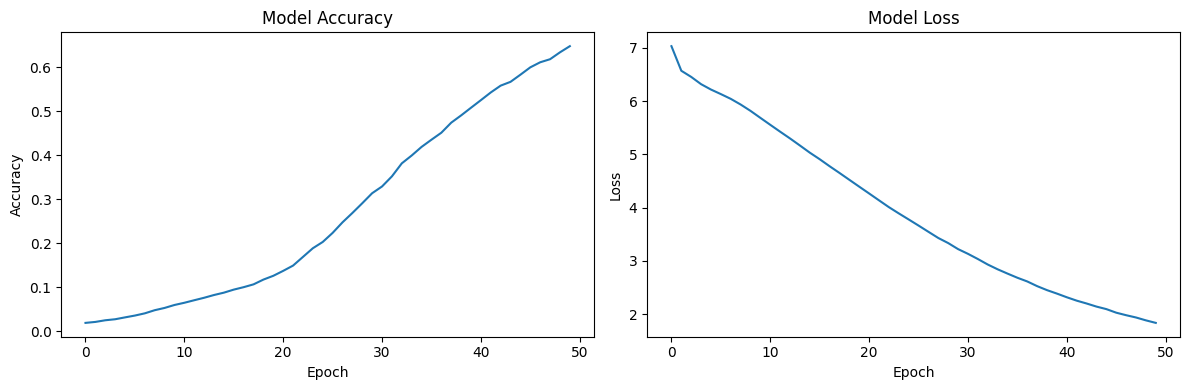

In [59]:
# Your code here :
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Plot training metrics
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [60]:
# Print final accuracy and loss
print("\nFinal accuracy:", history.history['accuracy'][-1])
print("Final loss:", history.history['loss'][-1])


Final accuracy: 0.6484112739562988
Final loss: 1.8346117734909058


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [61]:
seed_text = "Shall I compare thee to"  # Shakespeare-style seed text
next_words = 20  # Number of words to generate

# Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        # Convert the seed text to a sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predict the next word
        predicted = model.predict(token_list, verbose=0)
        # Get the index of the predicted word
        predicted = np.argmax(predicted, axis=-1)[0]
        # Get the actual word from the index
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Add the predicted word to the seed text
        seed_text += " " + output_word
    
    return seed_text

# Generate text
print("Generated text:")
print(generate_text(seed_text, next_words, model, max_sequence_len))

# Try with different seed texts
seed_texts = [
    "My love is like",
    "When in disgrace with",
    "Let me not to the"
]

print("\nMore examples:")
for seed in seed_texts:
    print("\nSeed:", seed)
    print("Generated:", generate_text(seed, next_words, model, max_sequence_len))

Generated text:
Shall I compare thee to a summer's day hate new ' young ' seen seen seen bearing their verse astonished astonished die be torn torn

More examples:

Seed: My love is like
Generated: My love is like a fever longing still still date pride of cross cross lie her light bail seen seen bail light groan alone

Seed: When in disgrace with
Generated: When in disgrace with fortune and men's eyes days outworn torn lie new bearing be art so the best best am thine ' '

Seed: Let me not to the
Generated: Let me not to the marriage of true minds to their chest lie to thine ' ' dear love ' ' ' they is yet


In [62]:
seed_text = "Shall I compare thee to"  # Shakespeare-style seed text
next_words = 30  # Number of words to generate
temperature = 0.7  # Slightly lower for more focused predictions

def generate_text(seed_text, next_words, model, max_sequence_len, temperature=0.7):
    generated_text = seed_text
    last_words = []  # Keep track of last few words
    line_length = 0  # Track line length for sonnet-like structure
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Get predictions
        predicted_probs = model.predict(token_list, verbose=0)[0]
        
        # Add small epsilon and normalize
        epsilon = 1e-10
        predicted_probs = predicted_probs + epsilon
        predicted_probs = predicted_probs / np.sum(predicted_probs)
        
        # Apply temperature and re-normalize
        predicted_probs = np.power(predicted_probs, 1.0/temperature)
        predicted_probs = predicted_probs / np.sum(predicted_probs)
        
        # Get top 10 words
        top_indices = np.argsort(predicted_probs)[-10:]
        
        # Expanded unwanted words list
        unwanted_words = ['dead', 'alone', 'gone', 'away', 'thee', 'thou', 'thy', 'thine']
        
        # Choose from top words, avoiding repetition and unwanted words
        for idx in reversed(top_indices):
            word = ""
            for w, index in tokenizer.word_index.items():
                if index == idx:
                    word = w
                    break
            
            # Check if word is suitable
            if (word not in last_words[-3:] and  # Not in last 3 words
                word not in unwanted_words and    # Not an unwanted word
                len(word) > 1):                   # Not a single character
                output_word = word
                break
        
        # Update last words
        last_words.append(output_word)
        if len(last_words) > 3:
            last_words.pop(0)
            
        generated_text += " " + output_word
        line_length += 1
        
        # Add line breaks to create sonnet-like structure (roughly 10 words per line)
        if line_length >= 10 or output_word in ['.', '?', '!', ';']:
            generated_text += "\n"
            line_length = 0
    
    return generated_text

# Generate text
print("Generated text:")
print(generate_text(seed_text, next_words, model, max_sequence_len))

Generated text:
Shall I compare thee to my love to score fall thence told you seen lie
 her men rage respect so bright best rare so true
 art bright die live new rare bright grow days so



Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [15]:
# Your code here :

Experiment with at least 3 different seed_text strings and see what happens!

In [63]:
# Your code here :
# Try with different seed texts
seed_texts = [
    "My love is like",
    "When in disgrace with",
    "Let me not to the"
]

print("\nMore examples:")
for seed in seed_texts:
    print("\nSeed:", seed)
    print("Generated:", generate_text(seed, next_words, model, max_sequence_len))


More examples:

Seed: My love is like
Generated: My love is like what when they have spent live seen now foes sit
 cross commend lie to you pride of their end friend
 heart releasing you torn seen bail ward cross grow sad


Seed: When in disgrace with
Generated: When in disgrace with fortune and men's eyes days outworn torn lie new bearing
 be art so the best not more dear friend bright
 kiss their treasure die so lie her ill rage faith


Seed: Let me not to the
Generated: Let me not to the marriage of true minds to their chest lie to men
 new ill bright best torn die so bold remain woe
 groan live so foes chary remain seen lie me new



In [ ]:
# Create a more complex model
model2 = Sequential([
    # Embedding layer with more dimensions
    Embedding(total_words, 150, input_length=max_sequence_len-1),
    
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    
    # Third LSTM layer
    LSTM(128),
    Dropout(0.2),
    
    # Dense layers with more units
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    
    # Output layer
    Dense(total_words, activation='softmax')
])

# Compile with a lower learning rate
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with more epochs and batch size
history2 = model2.fit(
    predictors,
    labels,
    epochs=200,
    batch_size=128,
    verbose=1
)